# Smartphone dataset example

Aerobic actions were recorded from subjects using the Inertial Measurement Unit (IMU) on an Apple iPhone 4 smartphone. The IMU includes a 3D accelerometer, gyroscope, and magnetometer*. Each sample was taken at 60Hz, and manually trimmed to 500 samples (8.33s) to eliminate starting and stopping movements. iPhone is always clipped to the belt on the right hand side.

Each file contains 500 rows, each row with the following information:
Acc_x,Acc_y,Acc_z,Gyr_x,Gyr_y,Gyr_z,Mag_x,Mag_y,Mag_z

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('talk', font_scale=1)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

# MOGP prediction on the sensor values

We use the 9 sensor values as channels, giving 9 channels in total.

All the data is sampled at 60Hz. With 500 samples (~8.3 segs) for each file.

In [3]:
def plot_experiment(model, ylims=None, title='Smartphone experiment'):
    """
    Plot smartphone mogptk example
    """
    x_train = model.data.X
    y_train = model.data.Y
    x_all = model.data.X_all
    y_all = model.data.Y_all
    x_pred = {i:array for i, array in enumerate(data.X_all)}
    
    try:
        x_pred, mean_pred, var_pred = model.predict(x_pred)
    except:
        pass
    
    names = ['Acc_x',
             'Acc_y',
             'Acc_z',
             'Gyr_x',
             'Gyr_y',
             'Gyr_z',
             'Mag_x',
             'Mag_y',
             'Mag_z']
    
    f, axarr = plt.subplots(3, 3, sharex=True, figsize=(20, 15))
    axarr = axarr.reshape(-1)
    
    for i in range(9):
        axarr[i].plot(x_train[i], y_train[i], '.k', label='Train')
        axarr[i].plot(x_all[i], y_all[i], '--', label='Test', c='gray')
        try:
            axarr[i].plot(x_pred[i], mean_pred[i], label='Test', c=sns.color_palette()[i])
            axarr[i].fill_between(x_pred[i].reshape(-1),
                                  mean_pred[i] + 2 * np.sqrt(var_pred[i]),
                                  mean_pred[i] - 2 * np.sqrt(var_pred[i]),
                                  label='95% c.i',
                                  color=sns.color_palette()[i],
                                  alpha=0.4)
        except:
            pass
        axarr[i].legend(ncol=2)
        axarr[i].set_title(names[i])
    plt.suptitle(title, y=1.02)
    plt.tight_layout()

## Example 1: Subject 1 bike 1,
Example consisting of measurement for the 9 sensors at 60Hz, with 500 samples per channel, while the person is in a bike.

In [4]:
df = pd.read_csv('data/HAR/Smartphone_Dataset/S05/bike3.csv', header=None)

# get values
y = df.values

# generate time values
t = (np.arange(0, 500) / 60).reshape(-1, 1)

In [5]:
# data container
data = mogptk.Data()

# add data to container
for channel in range(9):
    data.add(t, y[:, channel])
    
# check outdims
print('Input dims:', data.get_input_dims())
print('Number of channels:', data.get_output_dims())

Input dims: 1
Number of channels: 9


### Simulate sensor failure

In [6]:
# randomly sample from the data
for i in range(9):
    data.remove_randomly(channel=i, pct=0.7)
    
# drop chunks to simulate sensor failure
data.remove_range(0, None, 1)
data.remove_range(1, 0.5, 1.2)
data.remove_range(2, 6, None)
data.remove_range(3, 7, None)
data.remove_range(4, 7, None)
data.remove_range(6, 4, 4.5)
data.remove_range(7, 1, 3)
data.remove_range(8, 4, 6)

In [7]:
# define model
model = mogptk.MOSM(data, Q=3)

# initialize parameters with BNSE
model.init_params('means')

Building...


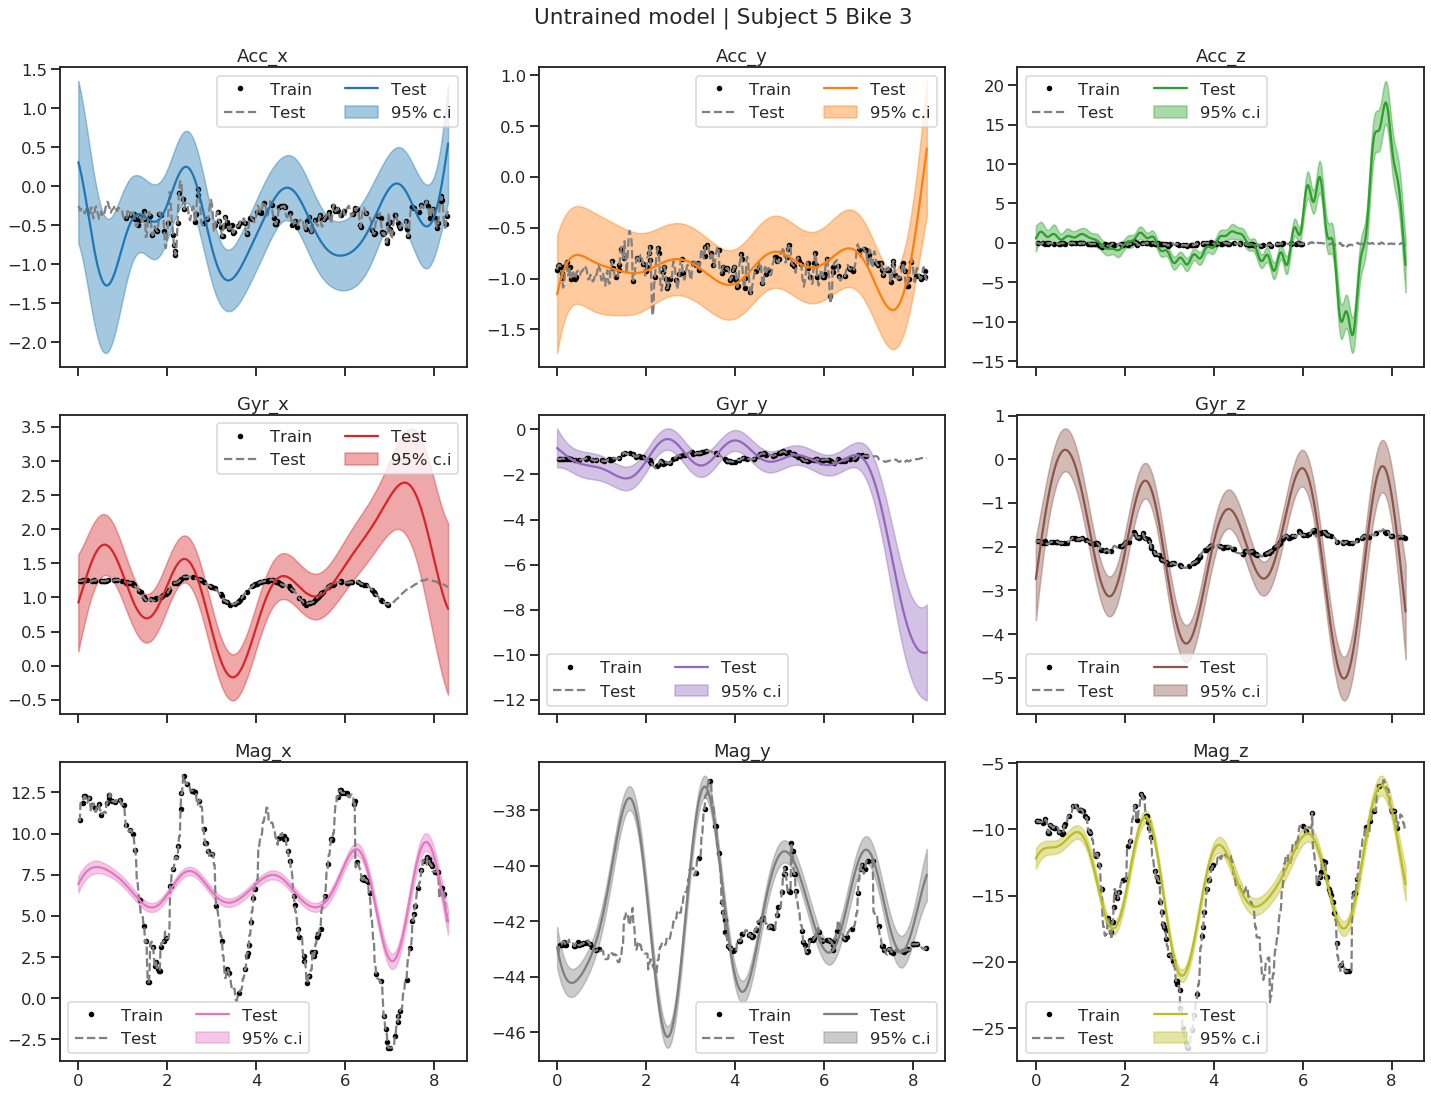

In [8]:
model.build()
plot_experiment(model, title='Untrained model | Subject 5 Bike 3')

In [9]:
%%time
# fit to data
model.train('L-BFGS-B', maxiter=5000, disp=True, tol=1e-15)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -411.687704
  Number of iterations: 5000
  Number of functions evaluations: 5328
Done
CPU times: user 28min 54s, sys: 3min 23s, total: 32min 17s
Wall time: 26min 42s


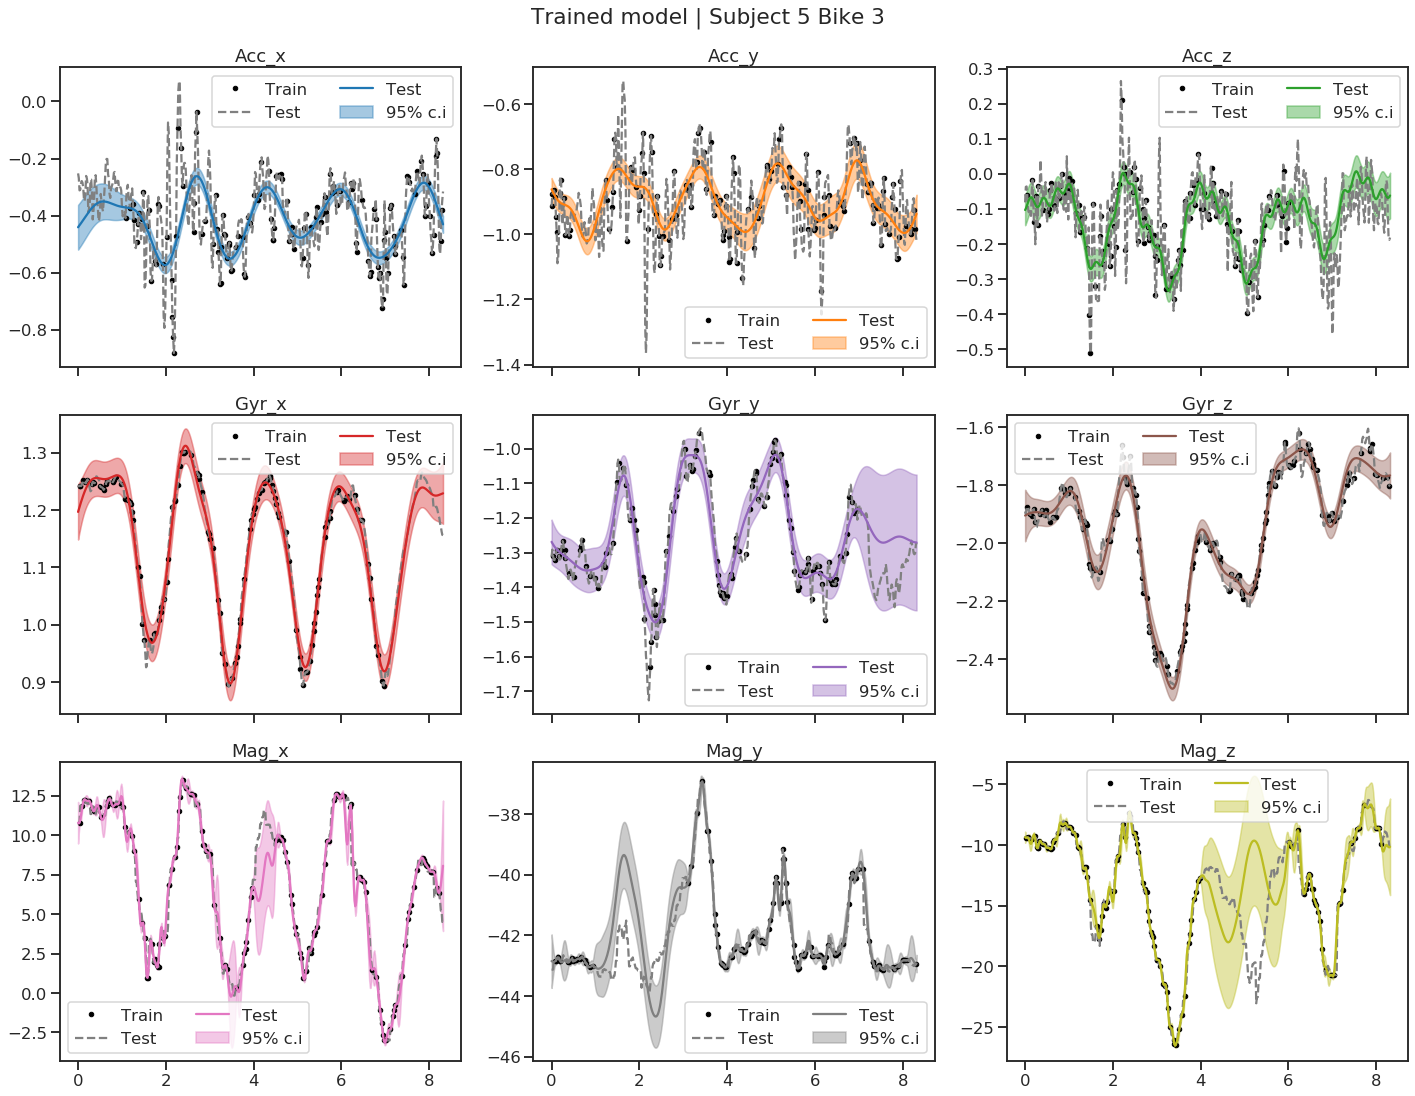

In [10]:
plot_experiment(model, title='Trained model | Subject 5 Bike 3')

## Example 2: Subject 5 walking 3
Example consisting of measurement for the 9 sensors at 60Hz, with 500 samples per channel, while the person is walking.

In [11]:
df = pd.read_csv('data/HAR/Smartphone_Dataset/S01/walking2.csv', header=None)

# get values
y = df.values

# generate time values
t = (np.arange(0, 500) / 60).reshape(-1, 1)

# data container
data = mogptk.Data()

# add data to container
for channel in range(9):
    data.add(t, y[:, channel])

In [12]:
# randomly sample from the data
for i in range(9):
    data.remove_randomly(channel=i, pct=0.7)
    
# drop chunks to simulate sensor failure
data.remove_range(0, None, 1)
data.remove_range(1, 0.5, 1.2)
data.remove_range(2, 6, None)
data.remove_range(3, 7, None)
data.remove_range(4, 7, None)
data.remove_range(6, 4, 4.5)
data.remove_range(7, 1, 3)
data.remove_range(8, 4, 6)

In [13]:
%%time
# define model
model = mogptk.MOSM(data, Q=3)

# initialize parameters with BNSE
model.init_params('means')

# fit to data
model.train('L-BFGS-B', maxiter=5000, disp=True, tol=1e-15)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 220.117577
  Number of iterations: 5000
  Number of functions evaluations: 5520
Done
CPU times: user 33min 58s, sys: 3min 44s, total: 37min 42s
Wall time: 28min 55s


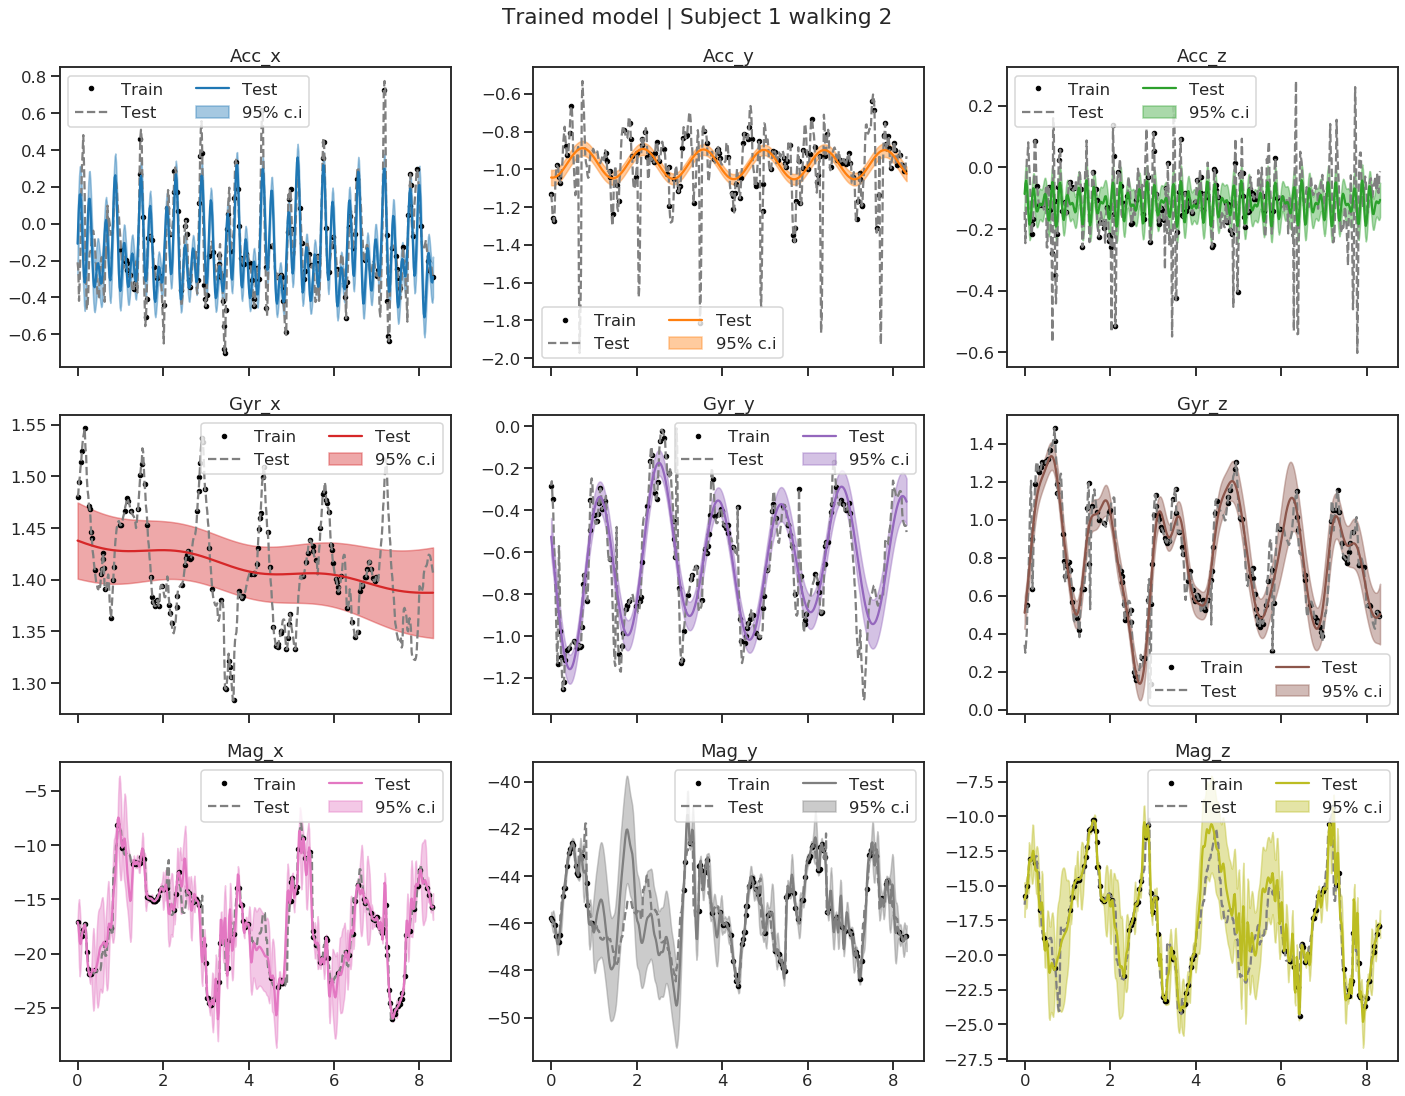

In [14]:
plot_experiment(model, title='Trained model | Subject 1 walking 2')